In [77]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd

Use pandas to read the dataset.

In [78]:
! pwd
data = pd.read_csv("../metadata/length_and_depth.csv")
data


/Users/felixgao/Desktop/Year3/STA378/OptimizationParameterTuning/Julia Notebook/src


,problem,nvar,objtype,variable_nvar,length,depth
0,NZF1,91,least_squares,True,250,8
1,arglina,100,least_squares,True,10404,9
2,arglinb,100,least_squares,True,40200,8
3,arglinc,100,other,True,39204,7
4,argtrig,100,other,True,497,7
...,...,...,...,...,...,...
100,tridia,100,other,True,398,6
101,vardim,100,other,True,798,6
102,vibrbeam,8,least_squares,False,481,13
103,watson,31,least_squares,False,3900,12


Let's start by exploring the data that we have in hand. Pandas has a nice function to summarize the mean and dispersion of each feature in our data frame:

In [79]:
data.describe().astype(int)

,nvar,length,depth
count,105,105,105
mean,77,2260,7
std,39,6260,2
min,5,109,4
25%,99,299,6
50%,100,594,7
75%,100,974,9
max,100,40200,13


In [80]:
data["objtype"].value_counts()

objtype
other            64
least_squares    41
Name: count, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x12a146990>,
 'caps': [<matplotlib.lines.Line2D at 0x12a146c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x12a146850>],
 'medians': [<matplotlib.lines.Line2D at 0x12a146e90>],
 'fliers': [<matplotlib.lines.Line2D at 0x12a146fd0>],
 'means': []}

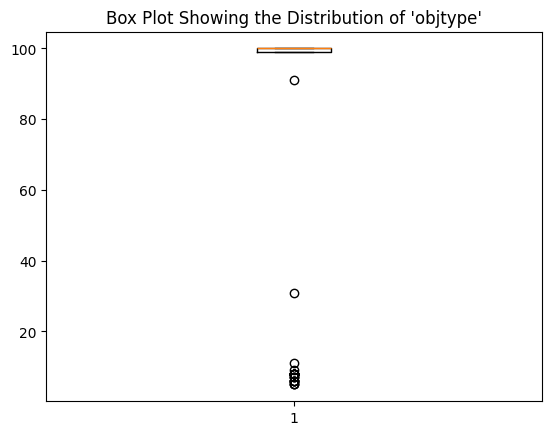

In [81]:
plt.title("Box Plot Showing the Distribution of 'objtype'")
plt.boxplot(data["nvar"])

In [82]:
pd.crosstab(data["objtype"], data["nvar"])

nvar,5,6,7,8,9,11,31,91,99,100
objtype,,,,,,,,,,
least_squares,3,4,3,11,1,1,1,1,0,16
other,0,1,0,0,0,0,0,0,12,51


In [83]:
pd.crosstab(data["objtype"], data["length"])

length,109,115,139,178,189,194,200,201,203,219,...,3900,5870,5881,6842,8105,10201,10404,30398,39204,40200
objtype,,,,,,,,,,,,,,,,,,,,,
least_squares,1,0,1,1,2,2,2,0,1,1,...,1,0,0,0,0,1,1,1,0,1
other,0,1,0,0,0,0,2,2,0,0,...,0,1,1,1,1,0,0,0,1,0


In [84]:
pd.crosstab(data["objtype"], data["depth"])

depth,4,5,6,7,8,9,10,11,12,13
objtype,,,,,,,,,,
least_squares,0,0,1,9,8,10,6,0,1,6
other,5,5,23,13,13,3,1,1,0,0


In [95]:
pd.crosstab(data["objtype"], data["variable_nvar"])

variable_nvar,False,True
objtype,,
least_squares,24,17
other,2,62


In [85]:
y = data["objtype"]

data_fets = data.drop(columns=["objtype", "problem"])

data_fets = pd.get_dummies(data_fets, drop_first=False)

feature_names = list(data_fets.columns)
feature_names

['nvar', 'variable_nvar', 'length', 'depth']

In [86]:
from sklearn.model_selection import train_test_split

# Split the data into X (dependent variables) and t (response variable)
X = data_fets
X = np.nan_to_num(X.replace([np.inf, -np.inf], np.nan), nan=0.0, posinf=1e9, neginf=-1e9)
t = np.array(y)

# First, we will use `train_test_split` to split the data set into
# 93 training+validation, and 10 test:
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=12/92, random_state=1)

# Then, use `train_test_split` to split the training+validation data
# into 80 train and 12 validation
X_train, X_valid, t_train, t_valid = train_test_split(X_tv, t_tv, test_size=12/80, random_state=1)

In [87]:
from sklearn.tree import DecisionTreeClassifier

# imports to visualize tree
from sklearn import tree as treeViz
import graphviz
import pydotplus
from IPython.display import display

In [88]:
def visualize_tree(model, max_depth=5):
    """
    Generate and return an image representing an Sklearn decision tree.

    Each node in the visualization represents a node in the decision tree.
    In addition, visualization for each node contains:
        - The feature that is split on
        - The entropy (of the outputs `t`) at the node
        - The number of training samples at the node
        - The number of training samples with true/false values
        - The majority class (heart disease or not)
    The colour of the node also shows the majority class and purity

    See here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

    Parameters:
        `model` - An Sklearn decision tree model
        `max_depth` - Max depth of decision tree to be rendered in the notebook.
         This is useful since the tree can get very large if the max_depth is
         set too high and thus making the resulting figure difficult to interpret.
    """
    dot_data = treeViz.export_graphviz(model,
                                       feature_names=feature_names,
                                       max_depth=max_depth,
                                       class_names=["least_squares", "other"],
                                       filled=True,
                                       rounded=True)
    return display(graphviz.Source(dot_data))

In [89]:
# Creating a DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)

tree.fit(X_train, t_train)

# Print the training and validation scores (accuracy)
print("Training Accuracy:", tree.score(X_train, t_train))
print("Validation Accuracy:", tree.score(X_valid, t_valid))

Training Accuracy: 0.8701298701298701
Validation Accuracy: 0.8571428571428571


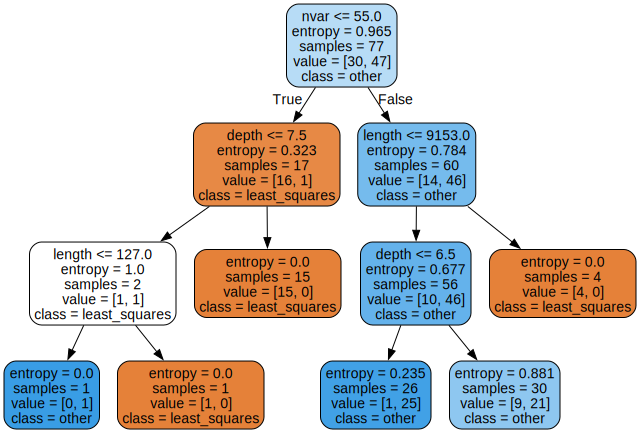

In [90]:
visualize_tree(tree, max_depth=3)

Hyperparameter Tuning for model parameters

In [91]:
def build_all_models(max_depths,
                     min_samples_split,
                     criterion,
                     X_train=X_train,
                     t_train=t_train,
                     X_valid=X_valid,
                     t_valid=t_valid):
    """
    Parameters:
        `max_depths` - A list of values representing the max_depth values to be
                       try as hyperparameter values
        `min_samples_split` - An list of values representing the min_samples_split
                       values to try as hyperpareameter values
        `criterion` -  A string; either "entropy" or "gini"

    Returns a dictionary, `out`, whose keys are the the hyperparameter choices, and whose values are
    the training and validation accuracies (via the `score()` method).
    In other words, out[(max_depth, min_samples_split)]['val'] = validation score and
                    out[(max_depth, min_samples_split)]['train'] = training score
    For that combination of (max_depth, min_samples_split) hyperparameters.
    """
    out = {}

    for d in max_depths:
        for s in min_samples_split:
            out[(d, s)] = {}
            # Create a DecisionTreeClassifier based on the given hyperparameters and fit it to the data
            tree = DecisionTreeClassifier(criterion=criterion, max_depth=d, min_samples_split=s)
            tree.fit(X_train, t_train)
            # TODO: store the validation and training scores in the `out` dictionary
            out[(d, s)]['val'] = tree.score(X_valid, t_valid)
            out[(d, s)]['train'] = tree.score(X_train, t_train)
    return out

In [92]:
# Hyperparameters values to try in our grid search
criterions = ["entropy", "gini"]
max_depths = [x + 1 for x in range(100)]
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

for criterion in criterions:
    print("\nUsing criterion {}".format(criterion))
    res = build_all_models(max_depths, min_samples_split, criterion)

    # TODO: complete this loop which should search for the optimal
    #  (max_depth, min_samples_split) given this criterion
    best_d, best_s = None, None
    best_accuracy = 0
    for d, s in res:
        if res[(d,s)]['val'] > best_accuracy:
          best_accuracy = res[(d,s)]['val']
          best_d, best_s = d, s
    print(f"The best parameters for criterion=\"{criterion}\" is max_depth={best_d} and min_samples_split={best_s} with accuracy={best_accuracy}.\n")


Using criterion entropy
The best parameters for criterion="entropy" is max_depth=1 and min_samples_split=2 with accuracy=0.9285714285714286.


Using criterion gini
The best parameters for criterion="gini" is max_depth=1 and min_samples_split=2 with accuracy=0.9285714285714286.



In [93]:
best_tree = DecisionTreeClassifier(criterion="entropy", max_depth=1, min_samples_split=2)
best_tree.fit(X_train, t_train)
print("Test Accuracy:", best_tree.score(X_test, t_test))

Test Accuracy: 0.8571428571428571


In [94]:
best_tree = DecisionTreeClassifier(criterion="gini", max_depth=1, min_samples_split=2)
best_tree.fit(X_train, t_train)
print("Test Accuracy:", best_tree.score(X_test, t_test))

Test Accuracy: 0.8571428571428571
